# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Downloading and loadng the data

In [2]:
# Loading the data
# import data_download

data_dir = "LFB-data"
# LFB_data = pd.read_csv(os.path.join(data_dir, "LFB Incident data - Datastore - with notional cost and UPRN from January 2009.csv"))
LFB_data = pd.read_csv(os.path.join(data_dir, "lfb_incident.csv"))

# Total memory used
print(f'Total Memory Used : {round(LFB_data.memory_usage(deep=True).sum()/(1024*1024), 2)} MB')
LFB_data.head()

Total Memory Used : 1486.66 MB


,IncidentNumber,DateOfCall,CalYear,TimeOfCall,HourOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,...,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
0,235138081,1-Jan-09,2009,0:00:37,0,Special Service,Special Service,RTC,Road Vehicle,Car,...,319.0,Battersea,342.0,Clapham,2.0,2.0,2.0,1.0,255.0,1.0
1,1091,1-Jan-09,2009,0:00:46,0,Special Service,Special Service,Assist other agencies,Outdoor,Lake/pond/reservoir,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2091,1-Jan-09,2009,0:03:00,0,Fire,Secondary Fire,NaN,Outdoor,Road surface/pavement,...,308.0,Edmonton,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
3,3091,1-Jan-09,2009,0:04:27,0,Fire,Secondary Fire,NaN,Outdoor,Domestic garden (vegetation not equipment),...,210.0,Hillingdon,NaN,NaN,1.0,1.0,1.0,1.0,255.0,2.0
4,5091,1-Jan-09,2009,0:05:39,0,Fire,Secondary Fire,NaN,Outdoor,Cycle path/public footpath/bridleway,...,233.0,Holloway,250.0,Holloway,1.0,2.0,2.0,1.0,255.0,1.0


### Primary Data analysis

In [3]:
LFB_data.shape

(1048575, 39)

In [4]:
LFB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   IncidentNumber                          1048575 non-null  object 
 1   DateOfCall                              1048575 non-null  object 
 2   CalYear                                 1048575 non-null  int64  
 3   TimeOfCall                              1048575 non-null  object 
 4   HourOfCall                              1048575 non-null  int64  
 5   IncidentGroup                           1048575 non-null  object 
 6   StopCodeDescription                     1048575 non-null  object 
 7   SpecialServiceType                      318402 non-null   object 
 8   PropertyCategory                        1048575 non-null  object 
 9   PropertyType                            1048575 non-null  object 
 10  AddressQualifier              

We can see that there are missing values

## Data Preprocessing

#### Time Processing

In [5]:
# We need to drop the existing Hour of call and create our own
LFB_data.drop('HourOfCall', axis=1, inplace=True)

# Create a new column from the DateOfCall column.
LFB_data['YearOfCall'], LFB_data['MonthOfCall'] = LFB_data['DateOfCall'].apply(lambda x: x.split("-")[2]),LFB_data['DateOfCall'].apply(lambda x: x.split("-")[1])
LFB_data['HourOfCall'] = LFB_data['TimeOfCall'].apply(lambda x: x.split(":")[0])

# Dropping unnecessary time columns
LFB_data.drop(['IncidentNumber','TimeOfCall','DateOfCall','CalYear'], axis=1, inplace = True)

#### Service and group processing

In [6]:
# We need to turn the incident group into ordinal encoding

# We convert the column from object to a category 
LFB_data['IncidentGroup'] = LFB_data['IncidentGroup'].astype('category')
LFB_data['IncidentGroup'] = LFB_data['IncidentGroup'].cat.codes # False alarm = 0, Fire = 1, special service = 2

# Drop the columns
LFB_data.drop(['StopCodeDescription','SpecialServiceType'], axis=1, inplace = True)
LFB_data.sample(4)

,IncidentGroup,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,...,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls,YearOfCall,MonthOfCall,HourOfCall
350790,0,Dwelling,Purpose Built Flats/Maisonettes - Up to 3 stor...,Within same building,NaN,E7,0.0,22207800.0,E09000025,NEWHAM,...,Stratford,1.0,2.0,2.0,1.0,260.0,2.0,11,Oct,20
584653,0,Dwelling,House - single occupancy,Correct incident location,NaN,SW16,0.0,21901521.0,E09000022,LAMBETH,...,Tooting,1.0,2.0,2.0,1.0,290.0,1.0,13,Dec,11
889535,0,Non Residential,Vehicle sales building,Correct incident location,SW19 3BZ,SW19,48051821.0,22104545.0,E09000024,MERTON,...,NaN,1.0,1.0,1.0,1.0,326.0,1.0,17,Jan,15
509204,1,Road Vehicle,Car,In street close to gazetteer location,E4 6JG,E4,NaN,NaN,E09000031,WALTHAM FOREST,...,NaN,1.0,1.0,1.0,2.0,580.0,17.0,13,Apr,1


#### Inc Geo data

In [7]:
# Inc Geo borough name and code all describe the same borough. 

# Number of distinct rows for each column
print(LFB_data[['IncGeo_BoroughCode', 'IncGeo_BoroughName']].nunique())

IncGeo_BoroughCode    33
IncGeo_BoroughName    33
dtype: int64


In [8]:
# we can join the two columns into one to avoid to many vatiables after encoding
LFB_data['IncGeo_Borough'] = LFB_data['IncGeo_BoroughCode'] + '-' +LFB_data['IncGeo_BoroughName']

# Finally we need to drop the two columns
LFB_data.drop(['IncGeo_BoroughCode','IncGeo_BoroughName'], axis=1, inplace=True)
LFB_data['IncGeo_Borough'].tail(3)

1048572         E09000026-REDBRIDGE
1048573    E09000031-WALTHAM FOREST
1048574        E09000032-WANDSWORTH
Name: IncGeo_Borough, dtype: object

In [9]:
# Similary for IncGeo code, ward name and ward name new, all describe the same ward

# Number of distinct rows for each column
print(LFB_data[['IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew']].nunique())
LFB_data['IncGeo_Ward'] = LFB_data['IncGeo_WardCode'] + '-' +LFB_data['IncGeo_WardName']

# Drop Unecessary Columns
LFB_data.drop(['IncGeo_WardCode','IncGeo_WardName','IncGeo_WardNameNew'], axis=1, inplace=True)
LFB_data['IncGeo_Ward'].sample(3)

IncGeo_WardCode        744
IncGeo_WardName       1285
IncGeo_WardNameNew    1271
dtype: int64


818204       E05009301-CORNHILL
265051    E05009379-King's Park
898355       E05000649-WEST END
Name: IncGeo_Ward, dtype: object

#### Slicing Northing_m and easting_m to 4 last digits

In [10]:
# process Northing and easting data and process it ito categorical data using pandas cut

LFB_data['Easting_rounded']= LFB_data['Easting_rounded'].apply(lambda x: int(str(x)[2:]))
LFB_data['Easting_rounded']= pd.cut(LFB_data['Easting_rounded'], bins=10, labels=['Easting_rounded_0','Easting_rounded_1','Easting_rounded_2','Easting_rounded_3','Easting_rounded_4','Easting_rounded_5','Easting_rounded_6','Easting_rounded_7','Easting_rounded_8','Easting_rounded_9'])

LFB_data['Northing_rounded']= LFB_data['Northing_rounded'].apply(lambda x: int(str(x)[2:]))
LFB_data['Northing_rounded']= pd.cut(LFB_data['Northing_rounded'], bins=10, labels=['Northing_rounded_0','Northing_rounded_1','Northing_rounded_2','Northing_rounded_3','Northing_rounded_4','Northing_rounded_5','Northing_rounded_6','Northing_rounded_7','Northing_rounded_8','Northing_rounded_9'])

In [11]:
LFB_data.nunique()

IncidentGroup                                  3
PropertyCategory                               9
PropertyType                                 290
AddressQualifier                              11
Postcode_full                             101469
Postcode_district                            326
UPRN                                       98510
USRN                                       47187
ProperCase                                    33
Easting_m                                  49456
Northing_m                                 38098
Easting_rounded                               10
Northing_rounded                              10
Latitude                                  297253
Longitude                                 299192
FRS                                            1
IncidentStationGround                        102
FirstPumpArriving_AttendanceTime            1200
FirstPumpArriving_DeployedFromStation        114
SecondPumpArriving_AttendanceTime           1197
SecondPumpArriving_D

In [12]:

grouping_labels = LFB_data['IncidentGroup']

#### Dropping Unecessary columns

In [13]:
LFB_data.drop(['IncidentGroup','Postcode_full','SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation'], axis=1,inplace=True)

## Exploratory data analysis

### Numerical data

In [14]:
# select numeric columns
df_numeric = LFB_data.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (1048575, 13)


array(['UPRN', 'USRN', 'Easting_m', 'Northing_m', 'Latitude', 'Longitude',
       'FirstPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'], dtype=object)

In [15]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
UPRN,907242.00,23843843874.00,49523278512.81,0.00,0.00,0.00,10022800743.00,200004000000.00
USRN,885704.00,20230482.00,4235058.73,0.00,20400898.00,21201309.00,22102010.00,99990116.00
Easting_m,567324.00,530635.68,10284.48,503588.00,525304.00,530777.00,536760.00,560925.00
Northing_m,567324.00,180376.97,7403.76,156761.00,176063.00,180991.00,184884.00,200906.00
Latitude,567324.00,51.51,0.17,0.00,51.47,51.51,51.55,51.69
Longitude,567324.00,-0.12,0.15,-0.51,-0.20,-0.12,-0.03,0.32
FirstPumpArriving_AttendanceTime,953420.00,321.27,142.68,1.00,231.00,297.00,381.00,1200.00
NumStationsWithPumpsAttending,1042619.00,1.35,0.61,1.00,1.00,1.00,2.00,46.00
NumPumpsAttending,1042619.00,1.56,0.79,1.00,1.00,1.00,2.00,106.00
PumpCount,1043123.00,1.59,1.68,1.00,1.00,1.00,2.00,951.00


We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

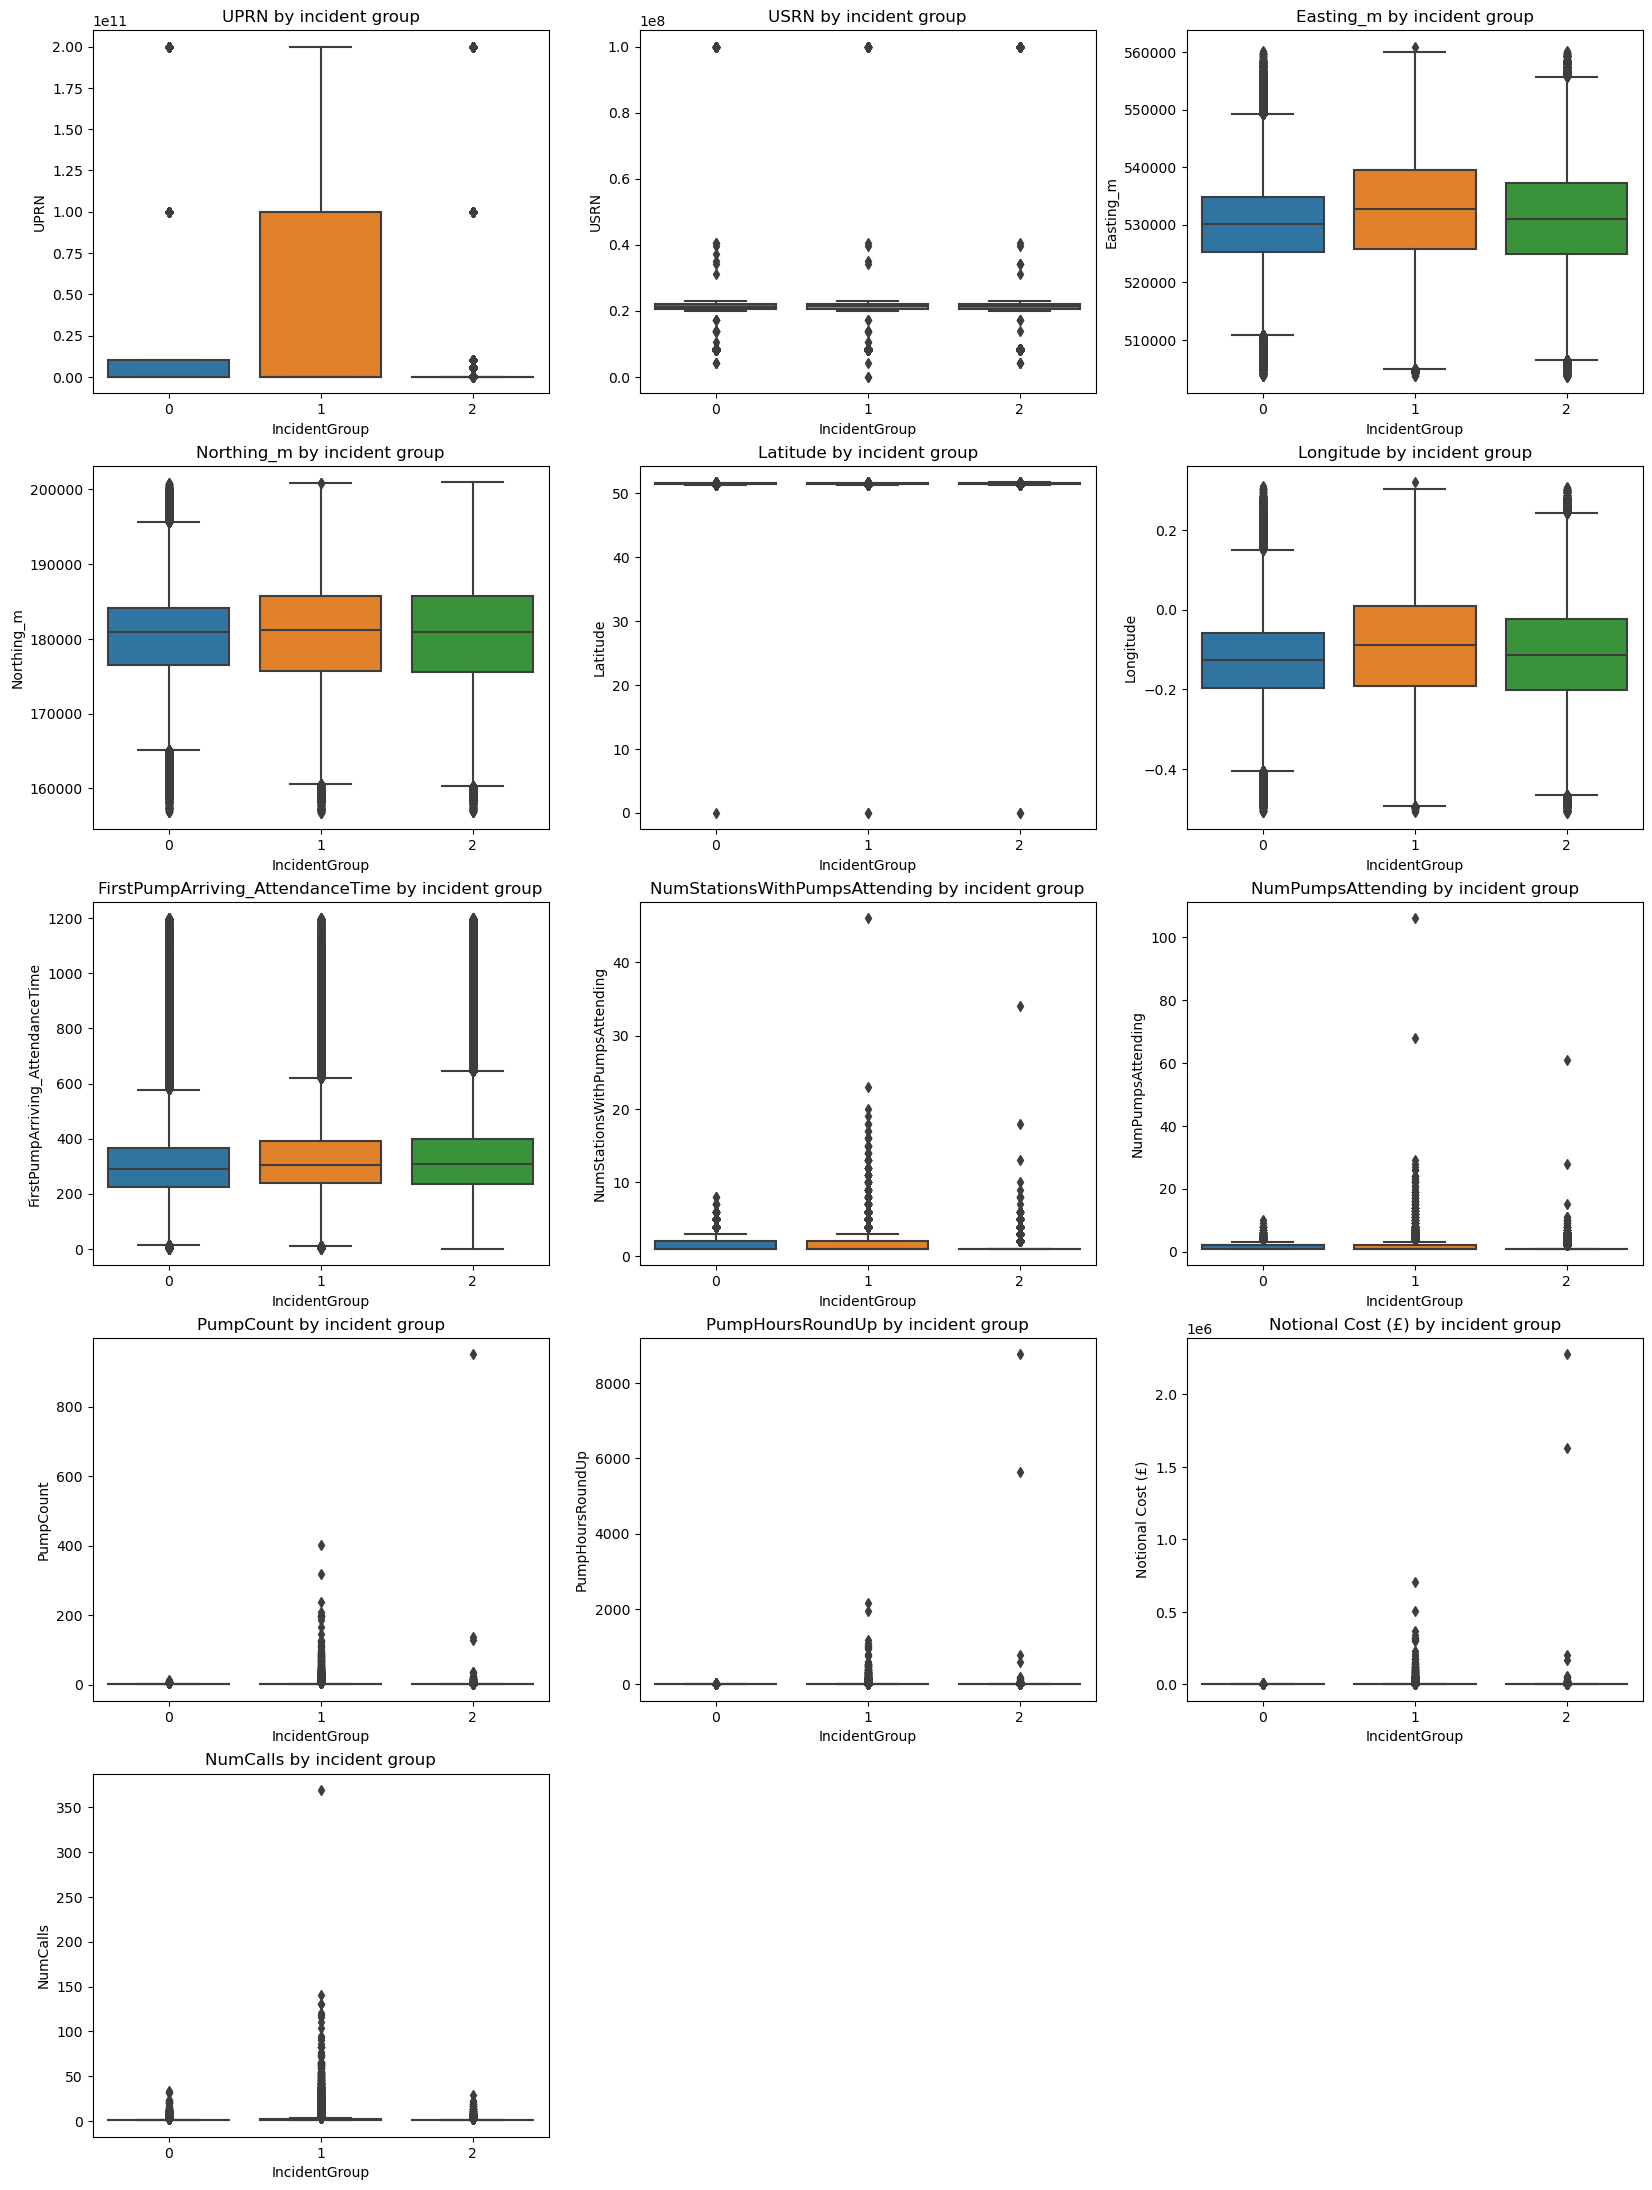

In [16]:
fig = plt.figure(figsize= (20,50))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(9,3, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x = grouping_labels)
    chart.set_title(column + " by incident group")

#### Missing values on Numeric data

In [17]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  13


UPRN                                141333
USRN                                162871
Easting_m                           481251
Northing_m                          481251
Latitude                            481251
Longitude                           481251
FirstPumpArriving_AttendanceTime     95155
NumStationsWithPumpsAttending         5956
NumPumpsAttending                     5956
PumpCount                             5452
PumpHoursRoundUp                      5591
Notional Cost (£)                     5591
NumCalls                              1836
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

#### Missing values

In [18]:

# for i in df_numeric[['UPRN', 'USRN', 'Easting_m', 'Northing_m','Easting_rounded', 'Northing_rounded',
#                     'FirstPumpArriving_AttendanceTime','SecondPumpArriving_AttendanceTime',
#                     'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
#                     'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']]:
for i in df_numeric.columns.values:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

In [19]:
df_numeric.describe()

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpHoursRoundUp,Notional Cost (£),NumCalls
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2.063003e+10,1.708816e+07,2.870966e+05,9.759167e+04,2.786732e+01,-6.439547e-02,2.921144e+02,1.339744e+00,1.547468e+00,1.583303e+00,1.341154e+00,3.829656e+02,1.341364e+00
std,4.677912e+10,8.297371e+06,2.645308e+05,9.004899e+04,2.566674e+01,1.242050e-01,1.643962e+02,6.168900e-01,7.968369e-01,1.680884e+00,1.162812e+01,3.200994e+03,1.493221e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.100464e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000070e+07,0.000000e+00,0.000000e+00,0.000000e+00,-1.261524e-01,2.090000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.600000e+02,1.000000e+00
50%,0.000000e+00,2.090042e+07,5.142050e+05,1.683470e+05,5.139891e+01,0.000000e+00,2.840000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.900000e+02,1.000000e+00
75%,1.000127e+10,2.190143e+07,5.315030e+05,1.813200e+05,5.151586e+01,0.000000e+00,3.700000e+02,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,3.260000e+02,1.000000e+00
max,2.000040e+11,9.999012e+07,5.609250e+05,2.009060e+05,5.169167e+01,3.197432e-01,1.200000e+03,4.600000e+01,1.060000e+02,9.510000e+02,8.761000e+03,2.277860e+06,3.690000e+02


#### Outliers in numerical data

In [20]:
for i in df_numeric.columns:
    df_numeric.fillna(df_numeric[i].mode()[0], inplace = True)
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].mean() - 3*df_numeric[i].std()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for UPRN :  -119707335808.85  to  160967401333.84
Range for USRN :  -7803952.06  to  41980274.84
Range for Easting_m :  -506495.7  to  1080688.97
Range for Northing_m :  -172555.31  to  367738.64
Range for Latitude :  -49.13  to  104.87
Range for Longitude :  -0.44  to  0.31
Range for FirstPumpArriving_AttendanceTime :  -201.07  to  785.3
Range for NumStationsWithPumpsAttending :  -0.51  to  3.19
Range for NumPumpsAttending :  -0.84  to  3.94
Range for PumpCount :  -3.46  to  6.63
Range for PumpHoursRoundUp :  -33.54  to  36.23
Range for Notional Cost (£) :  -9220.02  to  9985.95
Range for NumCalls :  -3.14  to  5.82

 ************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
UPRN,1048575.00,19380047766.66,42274006727.35,0.00,0.00,0.00,10001273681.00,160967401333.84
USRN,1048575.00,17066253.68,8153794.55,0.00,20000700.00,20900417.00,21901427.00,41980274.84
Easting_m,1048575.00,287096.64,264530.78,0.00,0.00,514205.00,531503.00,560925.00
Northing_m,1048575.00,97591.67,90048.99,0.00,0.00,168347.00,181320.00,200906.00
Latitude,1048575.00,27.87,25.67,0.00,0.00,51.40,51.52,51.69
Longitude,1048575.00,-0.06,0.12,-0.44,-0.13,0.00,0.00,0.31
FirstPumpArriving_AttendanceTime,1048575.00,290.26,157.35,0.00,209.00,284.00,370.00,785.30
NumStationsWithPumpsAttending,1048575.00,1.33,0.56,0.00,1.00,1.00,2.00,3.19
NumPumpsAttending,1048575.00,1.54,0.73,0.00,1.00,1.00,2.00,3.94
PumpCount,1048575.00,1.56,0.81,0.00,1.00,1.00,2.00,6.63


In [21]:
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

### Categorical Data

In [22]:
df_categorical = LFB_data.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(1048575, 15)

 ------------------------------------------------------------------------------------------------------------------------


array(['PropertyCategory', 'PropertyType', 'AddressQualifier',
       'Postcode_district', 'ProperCase', 'Easting_rounded',
       'Northing_rounded', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation', 'YearOfCall',
       'MonthOfCall', 'HourOfCall', 'IncGeo_Borough', 'IncGeo_Ward'],
      dtype=object)

In [23]:
df_categorical.sample(10)

,PropertyCategory,PropertyType,AddressQualifier,Postcode_district,ProperCase,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,YearOfCall,MonthOfCall,HourOfCall,IncGeo_Borough,IncGeo_Ward
442228,Dwelling,House - single occupancy,Correct incident location,N15,Haringey,Easting_rounded_2,Northing_rounded_8,London,Tottenham,Tottenham,12,Aug,11,E09000014-HARINGEY,E05000277-St. Ann's
566142,Non Residential,Ice rink,Correct incident location,E10,Waltham Forest,Easting_rounded_5,Northing_rounded_6,London,Leyton,Leyton,13,Oct,12,E09000031-WALTHAM FOREST,E05000603-Lea Bridge
47588,Non Residential,Hospital,Correct incident location,BR3,Bromley,Easting_rounded_7,Northing_rounded_6,London,Beckenham,Woodside,09,May,11,E09000006-BROMLEY,E05000120-Kelsey and Eden Park
187494,Outdoor,Domestic garden (vegetation not equipment),On land associated with building,UB1,Ealing,Easting_rounded_2,Northing_rounded_9,London,Southall,Southall,10,Jun,9,E09000009-EALING,E05000189-Southall Broadway
805841,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,SW7,Kensington And chelsea,Easting_rounded_6,Northing_rounded_9,London,Kensington,Kensington,16,Apr,14,E09000020-KENSINGTON AND CHELSEA,E05009401-QUEEN'S GATE
26580,Other Residential,Nurses'/Doctors' accommodation,Correct incident location,SM2,Sutton,Easting_rounded_6,Northing_rounded_2,London,Sutton,Sutton,09,Mar,21,E09000029-SUTTON,E05000557-Belmont
142307,Dwelling,House - single occupancy,Correct incident location,TW13,Hounslow,Easting_rounded_9,Northing_rounded_2,London,Feltham,Feltham,10,Jan,12,E09000018-HOUNSLOW,E05000352-Feltham West
699205,Dwelling,Converted Flat/Maisonettes - 3 or more storeys,Correct incident location,SW6,Hammersmith And fulham,Easting_rounded_5,Northing_rounded_6,London,Fulham,Fulham,15,Mar,21,E09000013-HAMMERSMITH AND FULHAM,E05000262-Sands End
126738,Outdoor,Tree scrub,Open land/water - nearest gazetteer location,SE9,Greenwich,Easting_rounded_4,Northing_rounded_4,London,Eltham,Eltham,09,Dec,20,E09000011-GREENWICH,E05000219-Eltham South
329236,Road Vehicle,Van,In street close to gazetteer location,N18,Enfield,Easting_rounded_3,Northing_rounded_2,London,Edmonton,Edmonton,11,Aug,23,E09000010-ENFIELD,E05000212-Upper Edmonton


In [24]:
# Show unique values for each categorcal variable

df_categorical.nunique()

PropertyCategory                            9
PropertyType                              290
AddressQualifier                           11
Postcode_district                         326
ProperCase                                 33
Easting_rounded                            10
Northing_rounded                           10
FRS                                         1
IncidentStationGround                     102
FirstPumpArriving_DeployedFromStation     114
YearOfCall                                 10
MonthOfCall                                12
HourOfCall                                 24
IncGeo_Borough                             33
IncGeo_Ward                              1380
dtype: int64

### Joining dataframes

In [25]:
final_df = pd.concat([df_numeric, df_categorical], axis = 1)
final_df.shape

(1048575, 28)

In [26]:
final_df.sample(7)

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,Easting_rounded,Northing_rounded,FRS,IncidentStationGround,FirstPumpArriving_DeployedFromStation,YearOfCall,MonthOfCall,HourOfCall,IncGeo_Borough,IncGeo_Ward
23600,1.201055e+07,20600700.0,520655.0,181161.0,51.516497,-0.262508,251.0,2.0,2.0,2.0,...,Easting_rounded_0,Northing_rounded_1,London,Acton,Acton,09,Mar,14,E09000009-EALING,E05000170-Acton Central
259274,0.000000e+00,20101418.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,1.0,...,Easting_rounded_6,Northing_rounded_2,London,Sidcup,NaN,10,Dec,14,E09000004-BEXLEY,E05011230-Sidcup
978897,2.001483e+08,20040000.0,519931.0,190838.0,51.603622,-0.269638,606.0,1.0,1.0,1.0,...,Easting_rounded_9,Northing_rounded_0,London,Stanmore,Stanmore,17,Nov,19,E09000003-BARNET,E05000044-BURNT OAK
1047836,5.088146e+06,20401035.0,531223.0,182059.0,51.522222,-0.109948,315.0,1.0,1.0,1.0,...,Easting_rounded_1,Northing_rounded_2,London,Shoreditch,Soho,18,Jul,8,E09000007-CAMDEN,E05000138-HOLBORN AND COVENT GARDEN
499552,0.000000e+00,20300815.0,0.0,0.0,0.000000,0.000000,317.0,2.0,2.0,2.0,...,Easting_rounded_6,Northing_rounded_4,London,Orpington,Orpington,13,Mar,13,E09000006-BROMLEY,E05000110-Chelsfield and Pratts Bottom
237239,1.001020e+10,20800247.0,540105.0,178678.0,51.489700,0.016647,149.0,2.0,2.0,2.0,...,Easting_rounded_0,Northing_rounded_8,London,East Greenwich,East Greenwich,10,Oct,16,E09000011-GREENWICH,E05000225-Peninsula
872271,0.000000e+00,20400376.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,1.0,...,Easting_rounded_9,Northing_rounded_5,London,Kentish Town,NaN,16,Nov,17,E09000007-CAMDEN,E05000139-KENTISH TOWN


### One hot encoding

In [27]:
final_df = pd.get_dummies(final_df)
final_df.tail()

,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,...,IncGeo_Ward_E05011481-Selsdon Vale & Forestdale,IncGeo_Ward_E05011482-Shirley North,IncGeo_Ward_E05011483-Shirly South,IncGeo_Ward_E05011484-South Croydon,IncGeo_Ward_E05011485-South Norwood,IncGeo_Ward_E05011486-Thornton Heath,IncGeo_Ward_E05011487-Waddon,IncGeo_Ward_E05011488-West Thornton,IncGeo_Ward_E05011489-WOODSIDE,IncGeo_Ward_E05011489-Woodside
1048570,0.000000e+00,20401327.0,0.0,0.0,0.000000,0.000000,360.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1048571,1.002529e+10,8400191.0,525896.0,180997.0,51.513885,-0.187061,391.0,2.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1048572,0.000000e+00,22302840.0,0.0,0.0,0.000000,0.000000,315.0,2.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1048573,1.002516e+10,22875400.0,539176.0,189185.0,51.584345,0.007429,419.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1048574,1.000230e+11,22900509.0,526925.0,171324.0,51.426718,-0.175721,282.0,1.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Adding the grouping data (labels)

In [28]:
final_df = pd.concat([grouping_labels, final_df], axis=1)
final_df.head(5)

,IncidentGroup,UPRN,USRN,Easting_m,Northing_m,Latitude,Longitude,FirstPumpArriving_AttendanceTime,NumStationsWithPumpsAttending,NumPumpsAttending,...,IncGeo_Ward_E05011481-Selsdon Vale & Forestdale,IncGeo_Ward_E05011482-Shirley North,IncGeo_Ward_E05011483-Shirly South,IncGeo_Ward_E05011484-South Croydon,IncGeo_Ward_E05011485-South Norwood,IncGeo_Ward_E05011486-Thornton Heath,IncGeo_Ward_E05011487-Waddon,IncGeo_Ward_E05011488-West Thornton,IncGeo_Ward_E05011489-WOODSIDE,IncGeo_Ward_E05011489-Woodside
0,2,0.000000e+00,0.0,528652.0,176830.0,51.475812,-0.148894,319.0,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2,0.000000e+00,0.0,530485.0,179007.0,51.494957,-0.121712,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.000000e+00,0.0,533773.0,194492.0,51.633342,-0.068488,308.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.000210e+11,21401491.0,507738.0,182805.0,51.533882,-0.437010,210.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.000000e+00,0.0,531058.0,185307.0,51.551441,-0.111120,233.0,1.0,2.0,...,0,0,0,0,0,0,0,0,0,0


# Dimensionality reduction

In [29]:
random.seed(10)
rand_num=random.sample(range(len(final_df)), 100000)
rand_num[:10]

[599159, 34167, 449722, 506002, 606172, 15552, 216109, 485050, 852829, 515161]

In [30]:
working_df = final_df.iloc[rand_num]

In [31]:
working_df.shape

(100000, 2379)

## T-Stochastic Neighbor Embedding (t-SNE)

In [32]:
%%time
import scipy
import time
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from scipy import stats
# A=scipy.spatial.distance.pdist(working_df, metric='euclidean')
# kendTSNE=[]
tsne = TSNE(n_components = 2, verbose=1, learning_rate=200, n_iter=500)
tsne_result = tsne.fit_transform(X=working_df)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.256s...
[t-SNE] Computed neighbors for 100000 samples in 1591.287s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

In [33]:
tsne_df = pd.DataFrame({"t-SNE 1":tsne_result[:,0], "t-SNE 2":tsne_result[:,1], "label":working_df['IncidentGroup']})
tsne_df.head()

,t-SNE 1,t-SNE 2,label
599159,16.503166,3.619889,1
34167,-6.724491,2.594217,2
449722,-4.037017,14.888946,2
506002,3.517268,4.033319,2
606172,-9.806808,-5.956420,2


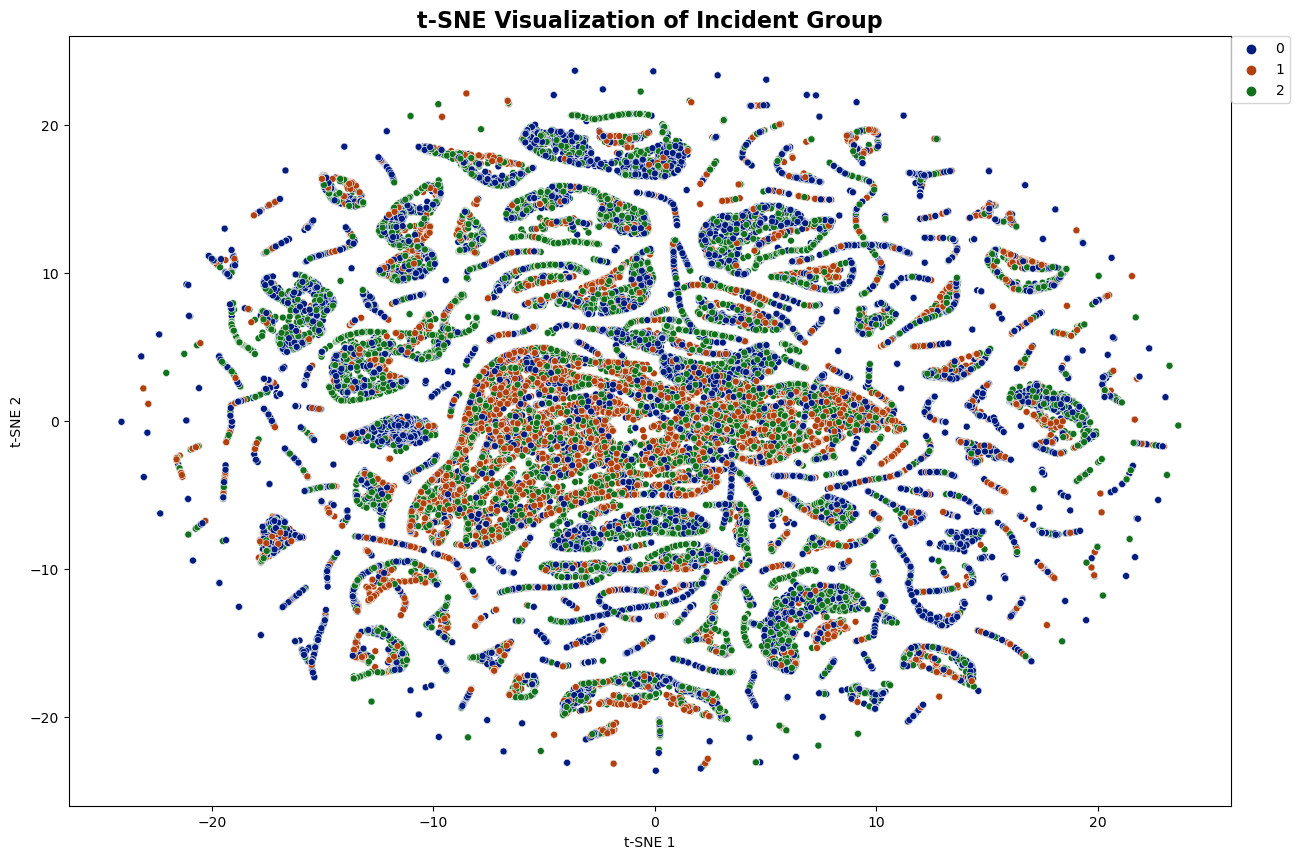

In [34]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df, hue='label', ax = ax, s=25, palette = 'dark')
sns.color_palette("hls", 10)
lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('t-SNE Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)

## Same Degree Distribution

In [35]:
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps

In [36]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i


class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded
